# GANomaly Notebook Results

## Initial Configurations

### Libraries import

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import umap
import cv2
from IPython.display import display, clear_output
from ipywidgets import interact, IntSlider

sys.path.append("../../")

In [2]:
from utils.metrics import shapiroWilks_test, dagostinoPearson_test, bartlett_test, levene_test, fOneWay_test
from utils.savers import generate_qq_plot

### Experiment selection

In [3]:
experiment_id = "0009"
root_path = "/home/jefelitman/Saved_Models/Anomaly_parkinson/"
for i in sorted(os.listdir("/home/jefelitman/Saved_Models/Anomaly_parkinson/")):
    if experiment_id in i:
        experiment_folder = os.path.join(root_path, i)
experiment_folder

'/home/jefelitman/Saved_Models/Anomaly_parkinson/0009_Ganomaly_2D-64x64x64'

## Quantitative metrics

### Metrics loading

In [4]:
train_metrics = pd.read_csv(os.path.join(experiment_folder, "metrics/train.csv"))
data = train_metrics
np.max(data, axis=0), np.min(data, axis=0), data.tail()

(epoch          19999.000000
 gen_error         15.548076
 disc_error         7.712474
 accuracy           0.930556
 precision          0.000000
 recall                  NaN
 specificity        0.930556
 f1_score           0.000000
 auc                0.000000
 dtype: float64,
 epoch          0.000000
 gen_error      0.938026
 disc_error     1.449824
 accuracy       0.486111
 precision      0.000000
 recall              NaN
 specificity    0.486111
 f1_score       0.000000
 auc            0.000000
 dtype: float64,
        epoch  gen_error  disc_error  accuracy  precision  recall  specificity  \
 19995  19995   0.987395    7.712474  0.791667        0.0     NaN     0.791667   
 19996  19996   0.991793    7.712474  0.777778        0.0     NaN     0.777778   
 19997  19997   0.956206    7.712474  0.763889        0.0     NaN     0.763889   
 19998  19998   1.024322    7.712474  0.763889        0.0     NaN     0.763889   
 19999  19999   1.011327    7.712474  0.791667        0.0     NaN     

In [5]:
test_metrics = pd.read_csv(os.path.join(experiment_folder, "metrics/test.csv"))
data = test_metrics
np.max(data, axis=0), np.min(data, axis=0), data.tail()

(epoch          19999.000000
 accuracy           0.942308
 precision          1.000000
 recall             0.931818
 specificity        1.000000
 f1_score           0.964706
 auc                1.000000
 dtype: float64,
 epoch          0.000000
 accuracy       0.096154
 precision      0.250000
 recall         0.034091
 specificity    0.437500
 f1_score       0.060000
 auc            0.159091
 dtype: float64,
        epoch  accuracy  precision    recall  specificity  f1_score       auc
 19995  19995  0.538462        1.0  0.454545          1.0  0.625000  1.000000
 19996  19996  0.538462        1.0  0.454545          1.0  0.625000  1.000000
 19997  19997  0.634615        1.0  0.568182          1.0  0.724638  0.994318
 19998  19998  0.500000        1.0  0.409091          1.0  0.580645  0.994318
 19999  19999  0.567308        1.0  0.488636          1.0  0.656489  1.000000)

### Train Graphics

In [6]:
path = os.path.join(experiment_folder, "outputs/graphics/quantitative/")
portions = 500
rows = 12
columns = 5
for metric in ["gen_error", "disc_error", "accuracy", "specificity"]:
    fig, axs = plt.subplots(rows, columns, figsize=(30, 25))
    fig.suptitle('{} over Epochs'.format(metric))
    for i in range(rows):
        for j in range(columns):
            axs[i, j].plot(train_metrics[metric][(i*columns+j)*portions:(i*columns+j+1)*portions])
            filename = 'train_{}.png'.format(metric)
    fig.savefig(path+filename)
    plt.close(fig)

### Test graphics

In [7]:
path = os.path.join(experiment_folder, "outputs/graphics/quantitative/")
portions = 500
rows = 12
columns = 5
for metric in test_metrics.columns[1:]:
    fig, axs = plt.subplots(rows, columns, figsize=(30, 25))
    fig.suptitle('{} over Epochs'.format(metric))
    for i in range(rows):
        for j in range(columns):
            axs[i, j].plot(test_metrics[metric][(i*columns+j)*portions:(i*columns+j+1)*portions])
            filename = 'test_{}.png'.format(metric)
    fig.savefig(path+filename)
    plt.close(fig)

## Qualitative metrics

### Errors loading

In [8]:
base_path = os.path.join(experiment_folder, "outputs/errors/")
for t in ["encoder", "contextual", "adversarial"]:
    for m in ["train", "test"]:
        classes = ["normal"] if m == "train" else ["normal", "abnormal"]
        for c in classes:
            all_data = "all_{}_{}".format(t, c)
            if all_data not in globals().keys():
                globals()[all_data] = np.r_[[]]
            
            errors = np.load(os.path.join(base_path, t, m, c+".npy"))
            globals()["{}_{}_{}".format(m, t, c)] = errors
            globals()[all_data] = np.concatenate([globals()[all_data], errors])

### Train means and stds

In [9]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal"]:
        data = globals()["train_{}_{}".format(t,c)]
        print("{i} error ({j}): {m} +- {s}".format(
            i = t,
            j = c,
            m = np.mean(data),
            s = np.std(data)
        ))
    print("")

encoder error (normal): 0.0009264776559171474 +- 0.0004471207119759325

contextual error (normal): 0.019738213650675282 +- 0.002739070569729305

adversarial error (normal): 0.02479663800396439 +- 0.007316580210885243



### Train statistical tests

In [10]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal"]:
        print("-------------------------------------------------")
        data = globals()["train_{}_{}".format(t,c)]
        norm_dist = stats.norm.rvs(loc=0, scale=1, size=data.shape)
        print("D'agostino-Pearson test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = dagostinoPearson_test(data)
        ))
        print("Shapiro-Wilks test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = shapiroWilks_test(data)
        ))
        print("Barlett test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = bartlett_test(data, norm_dist)
        ))
        print("Levene test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = levene_test(data, norm_dist)
        ))
        print("F1 test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = fOneWay_test(data, norm_dist)
        ))
        print("-------------------------------------------------")
    print("")

-------------------------------------------------
D'agostino-Pearson test for encoder (normal): 8.474920396583888e-08
Shapiro-Wilks test for encoder (normal): 1.320356568612624e-05
Barlett test for encoder (normal): 3.9805641513241316e-215
Levene test for encoder (normal): 1.3995227970500072e-19
F1 test for encoder (normal): 0.6673916985607875
-------------------------------------------------

-------------------------------------------------
D'agostino-Pearson test for contextual (normal): 0.18578983711245262
Shapiro-Wilks test for contextual (normal): 0.05470074340701103
Barlett test for contextual (normal): 4.085508764964249e-158
Levene test for contextual (normal): 1.1407100399873117e-22
F1 test for contextual (normal): 0.7728891818288579
-------------------------------------------------

-------------------------------------------------
D'agostino-Pearson test for adversarial (normal): 0.022386010988010803
Shapiro-Wilks test for adversarial (normal): 0.034361377358436584
Barlett t

### Test means and stds

In [11]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        data = globals()["test_{}_{}".format(t,c)]
        print("{i} error ({j}): {m} +- {s}".format(
            i = t,
            j = c,
            m = np.mean(data),
            s = np.std(data)
        ))
    print("")

encoder error (normal): 0.0007845970067137387 +- 0.00026725552387214986
encoder error (abnormal): 0.27461197083307937 +- 0.1165356131963963

contextual error (normal): 0.01762424921616912 +- 0.0008606450182498977
contextual error (abnormal): 0.16813773780383848 +- 0.021653087463851757

adversarial error (normal): 0.028014339972287416 +- 0.0023214755514515966
adversarial error (abnormal): 0.5509464016014879 +- 0.15037130974991733



### Test statistical tests

In [12]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        print("-------------------------------------------------")
        data = globals()["test_{}_{}".format(t,c)]
        norm_dist = stats.norm.rvs(loc=0, scale=1, size=data.shape)
        print("D'agostino-Pearson test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = dagostinoPearson_test(data)
        ))
        print("Shapiro-Wilks test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = shapiroWilks_test(data)
        ))
        print("Barlett test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = bartlett_test(data, norm_dist)
        ))
        print("Levene test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = levene_test(data, norm_dist)
        ))
        print("F1 test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = fOneWay_test(data, norm_dist)
        ))
        print("-------------------------------------------------")
    print("")

-------------------------------------------------
D'agostino-Pearson test for encoder (normal): 0.13489365385121824
Shapiro-Wilks test for encoder (normal): 0.003682413138449192
Barlett test for encoder (normal): 2.839843359722929e-47
Levene test for encoder (normal): 2.0697457295203404e-06
F1 test for encoder (normal): 0.01728164590949566
-------------------------------------------------
-------------------------------------------------
D'agostino-Pearson test for encoder (abnormal): 0.0010886848334437419
Shapiro-Wilks test for encoder (abnormal): 2.0602041331585497e-05
Barlett test for encoder (abnormal): 1.662967374225807e-53
Levene test for encoder (abnormal): 2.705204440027454e-20
F1 test for encoder (abnormal): 0.00035390118955347085
-------------------------------------------------

-------------------------------------------------
D'agostino-Pearson test for contextual (normal): 0.020447683352571678
Shapiro-Wilks test for contextual (normal): 0.10432406514883041
Barlett test fo

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


### All data means and stds

In [13]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        data = globals()["all_{}_{}".format(t,c)]
        print("{i} error ({j}): {m} +- {s}".format(
            i = t,
            j = c,
            m = np.mean(data),
            s = np.std(data)
        ))
    print("")

encoder error (normal): 0.0009006811742438003 +- 0.00042373272063283456
encoder error (abnormal): 0.27461197083307937 +- 0.1165356131963963

contextual error (normal): 0.019353856480765073 +- 0.0026339849598267778
contextual error (abnormal): 0.16813773780383848 +- 0.021653087463851757

adversarial error (normal): 0.025381674725477667 +- 0.006805825550124645
adversarial error (abnormal): 0.5509464016014879 +- 0.15037130974991733



### All data statistical tests

In [14]:
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        print("-------------------------------------------------")
        data = globals()["all_{}_{}".format(t,c)]
        norm_dist = stats.norm.rvs(loc=0, scale=1, size=data.shape)
        print("D'agostino-Pearson test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = dagostinoPearson_test(data)
        ))
        print("Shapiro-Wilks test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = shapiroWilks_test(data)
        ))
        print("Barlett test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = bartlett_test(data, norm_dist)
        ))
        print("Levene test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = levene_test(data, norm_dist)
        ))
        print("F1 test for {i} ({j}): {m}".format(
            i = t,
            j = c,
            m = fOneWay_test(data, norm_dist)
        ))
        print("-------------------------------------------------")
    print("")

-------------------------------------------------
D'agostino-Pearson test for encoder (normal): 1.2826473274465592e-09
Shapiro-Wilks test for encoder (normal): 1.084691689356987e-06
Barlett test for encoder (normal): 2.482249021085332e-266
Levene test for encoder (normal): 1.5920793644500475e-21
F1 test for encoder (normal): 0.2437121760706952
-------------------------------------------------
-------------------------------------------------
D'agostino-Pearson test for encoder (abnormal): 0.0010886848334437419
Shapiro-Wilks test for encoder (abnormal): 2.0602041331585497e-05
Barlett test for encoder (abnormal): 2.934085171306923e-54
Levene test for encoder (abnormal): 6.282852976626858e-22
F1 test for encoder (abnormal): 0.004516828064916507
-------------------------------------------------

-------------------------------------------------
D'agostino-Pearson test for contextual (normal): 0.017106973185072323
Shapiro-Wilks test for contextual (normal): 0.001671594800427556
Barlett test

### Train graphics

#### QQ plots

In [15]:
save_path = os.path.join(experiment_folder, "outputs/graphics/qualitative/")
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal"]:
        generate_qq_plot(globals()["train_{}_{}".format(t,c)], save_path, "train_{}_{}".format(t,c))

In [25]:
import statsmodels.api as sm
from scipy import stats

def min_max_scaler(data, new_max, new_min):
    data_std = (data - np.min(data)) / (np.max(data) - np.min(data))
    data_scaled = data_std * (new_max - new_min) + new_min
    return data_scaled

In [45]:
data = test_contextual_abnormal
stats.chisquare(data, ddof=data.shape[0]-2)

Power_divergenceResult(statistic=0.245390153632559, pvalue=0.620339881356887)

In [47]:
data_1 = test_encoder_normal
data_2 = test_encoder_abnormal
stats.mannwhitneyu(data_1, data_2)

MannwhitneyuResult(statistic=0.0, pvalue=1.1631165588810178e-10)

In [52]:
stats.norm()

KeyboardInterrupt: Interrupted by user

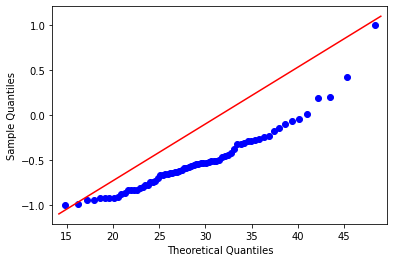

In [66]:
data = train_encoder_normal
for i in range(1, data.shape[0]):
    sm.qqplot(min_max_scaler(data, 1, -1), dist=stats.chi2(i))
    ax = plt.gca()
    plt.plot(ax.get_xlim(), ax.get_ylim(), color="r")
    input("Degree of freedom {}".format(i))
    clear_output()
    plt.close()

### Test graphics

#### Box plots

In [16]:
save_path = os.path.join(experiment_folder, "outputs/graphics/qualitative/")
rows = 1
columns = 3
fig, axs = plt.subplots(rows, columns, figsize=(15, 10))
for i, t in enumerate(["encoder", "contextual", "adversarial"]):
    data = "test_{}_".format(t)
    axs[i].boxplot([globals()[data+"normal"], globals()[data+"abnormal"]], labels=['Normal', 'Abnormal'])
    axs[i].set_title("{} errors".format(t))

filename = 'test_boxplot.png'
fig.savefig(save_path+filename)
plt.close(fig)

#### QQ plots

In [17]:
save_path = os.path.join(experiment_folder, "outputs/graphics/qualitative/")
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        generate_qq_plot(globals()["test_{}_{}".format(t,c)], save_path, "test_{}_{}".format(t,c))

### All data graphics

#### Box plots

In [18]:
save_path = os.path.join(experiment_folder, "outputs/graphics/qualitative/")
rows = 1
columns = 3
fig, axs = plt.subplots(rows, columns, figsize=(15, 10))
for i, t in enumerate(["encoder", "contextual", "adversarial"]):
    data = "all_{}_".format(t)
    axs[i].boxplot([globals()[data+"normal"], globals()[data+"abnormal"]], labels=['Normal', 'Abnormal'])
    axs[i].set_title("{} errors".format(t))

filename = 'all_data_boxplot.png'
fig.savefig(save_path+filename)
plt.close(fig)

#### QQ plots

In [19]:
save_path = os.path.join(experiment_folder, "outputs/graphics/qualitative/")
for t in ["encoder", "contextual", "adversarial"]:
    for c in ["normal", "abnormal"]:
        generate_qq_plot(globals()["all_{}_{}".format(t,c)], save_path, "all_data_{}_{}".format(t,c))

## Visual results

### UMAP latent vectors

In [20]:
base_path = os.path.join(experiment_folder, "outputs/latent_vectors/")
for t in ["in", "out"]:
    for m in ["train", "test"]:
        classes = ["normal"] if m == "train" else ["normal", "abnormal"]
        for c in classes:
            all_data = "all_{}_{}".format(t, c)
            if all_data not in globals().keys():
                globals()[all_data] = []
            
            data = "{}_{}_{}".format(m, t, c)
            globals()[data] = []
            path = os.path.join(base_path, t, m, c)
            for file in sorted(os.listdir(path)):
                vector = np.load(os.path.join(path, file))
                globals()[data].append(vector)
                globals()[all_data].append(vector)
            globals()[data] = np.r_[globals()[data]]
for t in ["in", "out"]:
    for c in ["normal", "abnormal"]:
        all_data = "all_{}_{}".format(t, c)
        globals()[all_data] = np.r_[globals()[all_data]]

In [21]:
save_path = os.path.join(experiment_folder, "outputs/graphics/visuals/")
for t in ["in", "out"]:
    for m in ["train", "test", "all"]:
        classes = ["normal"] if m == "train" else ["normal", "abnormal"]
        globals()["{}_mapped_{}".format(m, t)] = umap.UMAP(random_state = 8128).fit_transform(np.concatenate(
                [globals()["{}_{}_{}".format(m, t, c)] for c in classes], axis=0
            )
        )
        
        divisor = globals()["{}_{}_normal".format(m, t)].shape[0]
        plt.scatter(globals()["{}_mapped_{}".format(m, t)][:divisor,0],
            globals()["{}_mapped_{}".format(m, t)][:divisor,1], color="blue", s=5, label="Normal"
        )
        if "abnormal" in classes:
            plt.scatter(globals()["{}_mapped_{}".format(m, t)][divisor:,0],
                globals()["{}_mapped_{}".format(m, t)][divisor:,1], color="red", s=5, label="Abnormal"
            )
        plt.legend()
        plt.title("UMAP for {}put data in {}".format(t, m))
        filename = '{}_umap_{}put.png'.format(m, t)
        plt.savefig(save_path+filename)
        plt.close()

### Video comparision

In [ ]:
def show_all_data(volumes):
    frame_slider = IntSlider(value=32, min=1, max=volumes[0].shape[0], step=1)
    volume_slider = IntSlider(min=1, max=len(volumes), step=1)

    def update_frame_max(*args):
        frame_slider.max = len(sorted(os.listdir(path)))
    volume_slider.observe(update_frame_max, 'value')

    interact(lambda volume, frame: plt.imshow(volumes[volume-1][frame-1,:,:,1], cmap="gray"), 
             volume=volume_slider, frame=frame_slider
    );
show_all_data(classes[0])

In [ ]:
for i in range(0, 88):
    video_index = i
    mode = "test"
    video_class = "abnormal"

    base_path = os.path.join(experiment_folder, "outputs/samples/")
    for t in ["real", "fake", "substraction"]:
        path = os.path.join(base_path, t, mode, video_class)
        video = sorted(os.listdir(path))[video_index]
        data = "video_{}".format(t)
        globals()[data] = []
        for frame in sorted(os.listdir(os.path.join(path, video))):
            globals()[data].append(cv2.cvtColor(
                cv2.imread(
                    os.path.join(path, video, frame)
                ), cv2.COLOR_BGR2RGB
            ))
        globals()[data] = np.r_[globals()[data]]  

    assert video_real.shape[0] == video_fake.shape[0] == video_substraction.shape[0]

    widget = IntSlider(value=32, min=1, max=video_real.shape[0], step=1)

    interact(lambda frame: plt.imshow(video_real[frame-1]), frame=widget)
    interact(lambda frame: plt.imshow(video_fake[frame-1]), frame=widget)
    interact(lambda frame: plt.imshow(video_substraction[frame-1]), frame=widget)
    input("indice actual: {}".format(i))
    clear_output()